<a href="https://colab.research.google.com/github/yda-cyber/Hallucinator/blob/main/Hallucinator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Hallucinator with Binding/Cavity Control***

    This website is free and open to all users and there is no login requirement excepts for Google itself.
    Google may use any cookies, but the server itself does not.

In [11]:
#@title Install Dependencies
# @markdown Install ESMFold, OpenFold and Hallucinator
# @markdown - This will approximately use a few minutes
# @markdown - ESMFold can be used from ESMFold API (online, without GPU). Typically Faster for small proteins.

useESMFold = "online" # @param ["local", "online"]

import os
import time

if not os.path.isfile('install-Basis'):
  print("[PREPR]: Installing Basic python enviornments.")
  os.system("pip install pyKVFinder==0.6.0")
  os.system("pip install numpy==1.23.5")
  os.system("git clone https://github.com/yda-cyber/Hallucinator.git")
  open('install-Basis', 'w').close()

# Install ADFR
if not os.path.isfile('install-ADFR'):
  print("[PREPR]: Installing ADFR.")
  os.system("wget -O install-ADFR https://ccsb.scripps.edu/adfr/download/1028/")
  os.system("chmod a+x install-ADFR")
  !echo -e "Y\n ADFR" | ./install-ADFR >/dev/null 2>&1
  os.chdir('ADFR/')
  os.system('tar -zxvf ADFRsuite_x86_64Linux_1.0.tar.gz')
  os.chdir('ADFRsuite_x86_64Linux_1.0/')
  os.system('echo -e "Y" | ./install.sh >/dev/null 2>&1')
  os.system('cp bin/prepare_receptor ../../.')
  os.chdir('../..')

if not os.path.isfile('qvina-w'):
  print("[PREPR]: Installing Qvina-W.")
  os.system("git clone https://github.com/QVina/qvina.git")
  os.system("chmod +x qvina/bin/qvina-w")
  os.system("cp qvina/bin/qvina-w .")

#os.makedirs("results", exist_ok=True)
#os.makedirs("molecules", exist_ok=True)

if useESMFold == 'local':
  if not os.path.isfile("esmfold.model"):

    os.system("apt-get install aria2 -qq")
    print("[PREPR]: Downloading ESMFold from ColabFold.")
    os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

    # wait for Params to finish downloading...
    if os.path.isfile(f"esmfold.model.aria2"):
      print("[PREPR]: Downloading in progress.")
    while os.path.isfile(f"esmfold.model.aria2"):
      time.sleep(5)

    if not os.path.isfile("FoldInstalled.state"):
      commit_id = "6908936b68ae89f67755240e2f588c09ec31d4c8"
      print("[PREPR]: Installing ESMfold Dependencies.")
      os.system("pip install -q omegaconf \"pytorch_lightning<2\" \"torch<2\" biopython ml_collections einops py3Dmol")
      os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")
      os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit_id}")
      print("[PREPR]: Installing ESMfold")
      os.system("pip install -q git+https://github.com/sokrypton/esm.git")
      os.system("touch FoldInstalled.state")

In [12]:
#@title Import Losses and Modules

from Hallucinator.ProteinHallucination import Protein_History_MCMC_Logger

from Hallucinator.modules.Predict_ESM import predict_esm
from Hallucinator.modules.Compute_RMSD import compute_rmsd
from Hallucinator.modules.Init_Sequence import init_sequence
from Hallucinator.modules.Select_Mutation import select_mutation
from Hallucinator.modules.Mutations_BLOSUM62 import mutation_blosum62

from Hallucinator.loss.Loss_Function import LossFunction

from Hallucinator.loss.Compute_Cavity_Volume_Loss import CavityVolumeLoss
from Hallucinator.loss.Compute_Local_Distance_Loss import LocalDistanceLoss
from Hallucinator.loss.Compute_Secondary_Ratio_Loss import SecondaryRatioLoss
from Hallucinator.loss.Compute_Contact_Density_Loss import ContactDensityLoss
from Hallucinator.loss.Compute_Cavity_Similarity_Loss import CavitySimilarityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Loss import CavityContainingLoss
from Hallucinator.loss.Compute_Protein_Containing_Loss import ProteinContainingLoss
from Hallucinator.loss.Compute_Preserve_Structure_Loss import PreserveStructureLoss
from Hallucinator.loss.Compute_Truncated_Average_PLDDT_Loss import TruncatedAveragePLDDTLoss
from Hallucinator.loss.Compute_Molecule_Binding_Affinity_Loss import MoleculeBindingAffinityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Flexible_Loss import CavityContainingFlexibleLoss

In [13]:
import os
#@title Basic Settings
Jobname = 'UUID4' #@param {type:"string"}
Length = 120 #@param {type: "number"}
Steps = 1000 #@param {type: "number"}
Output_Render_Frequency = 100 #@param {type: 'number'}
Start_From_Known_Sequence = True #@param {type:"boolean"}
#@markdown - Only when you select to start from known sequence, the Intial Sequence and Preservation will be used
Initial_Sequence = 'KFEDITEKVFRYTAFQNTAIQSVQAVSDLLLTEGDKLYNTKWDRSVKSDEILYTQLESFKAKLDTEYPAALFNLSQVKAGQMMSSAMMLLSKVNSVMRSGWLADLPVSTLKQRLKAITEE' #@param {type:"string"}
#@markdown - The initial mutation rate should be smaller than 1.
Initial_Mutation_Rate = 0 #@param {type:"number"}
#@markdown - To preserve Residues, you should set Free Guess and Mutation Rate to be zero. Use ";" to seperate.
Preserved_Residues = "5;6;8" #@param {type:"string"}
#@markdown - Use ; to seperate unwanted amino acids
Exclude_Amino_Acid = "C;H" #@param {type:"string"}
#@markdown - Number of guesses before starting hallucination
N_Free_Guess = "0" #@param [0, 5, 10]
#@markdown - Rules for mixing multiple losses
Loss_Rule = 'Sum' #@param ['Sum', 'Max']

N_Free_Guess = int(N_Free_Guess)

#@markdown - If do not save to google drive, one may have potential data loss. But this is not required.
#@markdown - A new Folder named "Hallucinator" will be created under your drive.
Save_To_Google_Drive = False #@param {type: "boolean"}
if Save_To_Google_Drive:
  from google.colab import drive
  drive.mount('/content/drive')
  # Create a symbolic link
  symlink_path = '/content/my_drive'  # You can name this whatever you like
  target_path = '/content/drive/My Drive'

  # Remove the symlink if it already exists
  if os.path.exists(symlink_path) or os.path.islink(symlink_path):
      os.unlink(symlink_path)

  os.symlink(target_path, symlink_path)
  # Path to the folder we want to check/create
  folder_path = '/content/my_drive/Hallucinator/'
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)
      print('Folder "Hallucinator" created in Google Drive.')
  os.makedirs('/content/my_drive/Hallucinator/results', exist_ok=True)
else:
  os.makedirs("results", exist_ok=True)
  folder_path = '/content/'

os.makedirs("molecules", exist_ok=True)

Saving PFP-NDI.pdbqt to PFP-NDI.pdbqt
Moved "PFP-NDI.pdbqt" to the ./molecules/ directory
[STLSS]: The Explicit Binding Loss use file molecules/PFP-NDI.pdbqt
[MBLRF]: Computing Average Binding Affinity for 50 Reference PDBs
[MBLRF]: This will take several minutes.


Saving PFP-NDI.pdb to PFP-NDI.pdb
Moved "PFP-NDI.pdb" to the ./molecules/ directory
[STLSS]: The Implicit Cavity Loss use file moleculesPFP-NDI.pdb


FileNotFoundError: ignored

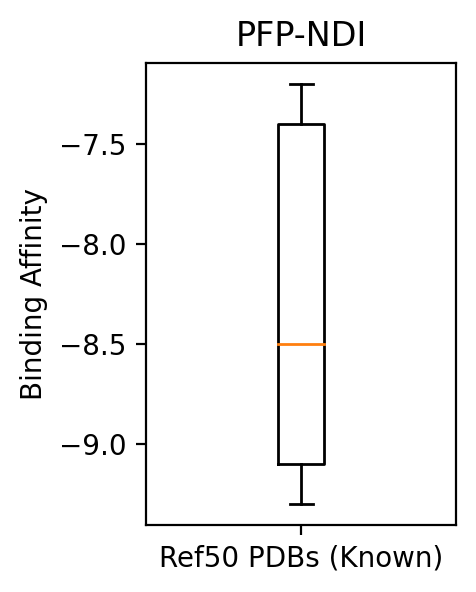

In [14]:
#@title Set Loss.
#@markdown All Loss will be finally normalized. And Max_loss is used for Weighting.
#@markdown - For other loss or customizing loss, please use a downloaded version.


PLDDTLoss = []
POSLoss = []
#@markdown Parameters for Truncated PLDDT Loss (With max loss=1)
Truncated_PLDDT_Loss = True
target_PLDDT =  80 #@param {type:"number"}
pldd_target = target_PLDDT

if Truncated_PLDDT_Loss:
  PLDDTLoss += [TruncatedAveragePLDDTLoss(30, target_PLDDT)]

#@markdown Parameters for Contact Density Loss:
#@markdown - Enhance numbers of contact in proteins to make it globularm typically value: 0.035 for L<=150, 0.015 for L<=400
Contact_Density_Loss = True
target_density = 0.02 #@param {type:"number"}
max_loss_Contact =  1 #@param {type:"number"}
activate_PLDDT_Contact = 30 #@param {type: "number"}
cdl_max_loss, cdl_target, cdl_activate = max_loss_Contact, target_density, activate_PLDDT_Contact

if Contact_Density_Loss:
  POSLoss += [ContactDensityLoss(target_density=cdl_target, max_loss=cdl_max_loss,
                 plddt_activate_value=cdl_activate)]

#@markdown Parameters for Explicit Binding Loss (Time Consuming):
Explicit_Binding_Loss = True #@param {type:"boolean"}
#@markdown - Target value varies for different molecules, one can provide a positive numerical value or use Auto functions. Auto functions benchmarked the binding with N(N<=49) reference peptides and use 1.5*max(score)
#@markdown - The Auto function may need a significant amount of time (~Dock Ntimes)
target_affnity =  "Auto-5" #@param {type:"raw"}

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

max_loss_Affnity =  3 #@param {type:"number"}
activate_PLDDT_Affnity = 40 #@param {type: "number"}
mbl_max_loss, mbl_target, mbl_activate = max_loss_Affnity, target_affnity, activate_PLDDT_Affnity


#@markdown - If you selected EBL (and not example), please upload the required file (Ligand in PDBQT Format). Examples are in Hallucinator/Molecules.
#@markdown - Unclick the use examples to upload your file:

use_example_PDBQT = False #@param {type:"boolean"}
mbl_file = None
if Explicit_Binding_Loss and not use_example_PDBQT:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  mbl_file = 'molecules/'+f
if use_example_PDBQT:
  mbl_file = 'Hallucinator/molecules/Example.pdbqt'
print('[STLSS]: The Explicit Binding Loss use file', mbl_file)


if Explicit_Binding_Loss:
  POSLoss += [MoleculeBindingAffinityLoss(mbl_file, max_loss=mbl_max_loss,
                      target_score=mbl_target,
                      plddt_activate_value=mbl_activate)]

#@markdown Parameters for Implicit Cavity Loss (Time Efficient with Step>=0.5):
Implicit_Cavity_Loss = True #@param {type:"boolean"}
#@markdown - Target value varies for different molecules. In A^3
Tolerate_Volume_Diff =  500 #@param {type:"number"}
#@markdown - Smaller Step will make cavity calculation more accurate but also more expensive
Step_KVFinder = 0.6 #@param {type:"number"}
#@markdown - Whether sidechains are ignored when calculating cavities.
Ignore_Sidechains = False #@param {type: "boolean"}
max_loss_Cavity =  3 #@param {type:"number"}
activate_PLDDT_Cavity = 50 #@param {type: "number"}
ccl_max_loss, ccl_activate = max_loss_Cavity, activate_PLDDT_Cavity


#@markdown - If you selected ICL (and not example), please upload the required file (Ligand in PDB Format, the Occ column to be vdw radius). Examples are in Hallucinator/Molecules.
#@markdown - Unclick the use examples to upload your file:
use_example_PDB = False #@param {type:"boolean"}
ccl_file = None

if Implicit_Cavity_Loss and not use_example_PDB:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  ccl_file = 'molecules/'+ f
if use_example_PDB:
  ccl_file = 'Hallucinator/molecules/Example.pdb'
print('[STLSS]: The Implicit Cavity Loss use file', ccl_file)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

if Implicit_Cavity_Loss:
  POSLoss += [CavityContainingLoss(ccl_file, volume_factor=0.01,
                  volume_expansion=Tolerate_Volume_Diff,
                  similarity_factor=20, similarity_target_diff=0,
                  sample_points=10, step=Step_KVFinder,
                  backbone_cavity=Ignore_Sidechains,
                  max_loss=ccl_max_loss, plddt_activate_value=ccl_activate)]



In [ ]:
#@title Start Hallucinating!
import gc
import torch
import numpy as np

#if 'logger' in dir():
#  del logger

if torch.cuda.is_available():
  torch.cuda.empty_cache()

gc.collect()

leng = len(Initial_Sequence) if Start_From_Known_Sequence else Length
seqc = Initial_Sequence if Start_From_Known_Sequence else None
mutn = Initial_Mutation_Rate if Start_From_Known_Sequence else 0
exaa = Exclude_Amino_Acid.split(';')
job_name = None if Jobname == 'UUID4' else Jobname
try:
  pres = np.asarray(Preserved_Residues.split(';')).astype('int')
except:
  pres = None
pres_resid = pres if Start_From_Known_Sequence else None
seqc = [seqc, None, mutn] if Start_From_Known_Sequence else None

logger = Protein_History_MCMC_Logger(
        length=leng, excluded_aas=exaa, temp=[.05, .01, (1e-9, 5)], step=Steps,
        free_guess=N_Free_Guess, seqc_provided=seqc, preserve_resid=pres_resid,
        temp_control='Adaptive', job_name=job_name,
        guess_loss_ignore=['TruncatedAveragePLDDTLoss', 'MoleculeBindingAffinityLoss'],
        plddt_loss=PLDDTLoss, pos_loss=POSLoss,
        form_loss=lambda x, y: x+y, plddt_rule=np.mean,
        pos_rule=np.sum if Loss_Rule=='Sum' else np.max,
        loss_info=True, server_online=(useESMFold=='online'),
        save_dirs=folder_path)

logger.mcmc(print_level=Output_Render_Frequency, allow_convergence=0)


### **Instructions **
---
Quick Start

    Define the required parameters into the input field. Then press "Runtime" -> "Run all".
    The process consists of several steps, with the currently running step indicated by a circle with a stop sign next to it.

---

Setting Up Your Job

    Fill in the details like job name, temperature, sequence length, steps, output frequency.
    · Set If you're starting from a known sequence (see *Restart*).
    · If the Job name is "UUID4", then a short UUID will be assigned.
    · Set to to exclude or not specific amino acids. Use ";" to seperate any characters. (e.g. C;H;P)
    · Set to to Preserve any site(s) from mutation. Use ";" to seperate any indexes. (e.g. 5;6;7)    
    · Set the number of random guesses before hallucination (N Free Guess).
    · Set the initial mutation rate if start with a known sequence (should be <=1)   
    · If the loss keep oscillate among thousands of steps, try a lower MC temperature. (0.5 is a good choice but can be lowered)
    · Temperature will be arised on-the-fly if the no candidate is adopted.
    · Job will never stop due to loss values. Even loss=0 the job will continue, it only stops when the maximum loops reached.

    User can opt to save results to Google Drive to avoid data loss.
    · A new folder in the Google Drive will be created to store the data.
    · File(s) about Protein structures and binding locations will be stored.
    · Otherwise, the sequence(s) will only be outputed in the cell.   

---
Configuring Loss Parameters

    Adjust settings for different types of losses such as Truncated PLDDT Loss, Contact Density Loss, etc.
    Set parameters like target values, max loss, and activation PLDDT (the PLDDT activate the loss) as per your requirements.
    The more losses defined, the harder the job to converge.

    Truncated PLDDT Loss is required.
    · Please refer to [Zeming Lin et al.](https://www.science.org/doi/10.1126/science.ade2574)

    Contact Density Loss is required.
    · Typically set to be smaller than 0.0155 for L<=400 and 0.035 for L<=150.
    · Modify per your requirement. Higher Contact density is known to prefer beta structures and harder to search.
    · Please refer to [Marco Punta et al.](https://academic.oup.com/bioinformatics/article/21/13/2960/197036)

    Explict Binding Loss is optional.
    · This loss used Quickvina-W. Each turn 16 blind search is performed.
    · This loss requires additional file of ligand (in PDBQT format) with all rotatable angles.
    · An example file is provided with the loss. If one opt not to use the example, then it will ask for uploading.
    · This loss function requires targeted value (positive). It can be given, or automatically assigned ("Auto-N", N<=50)
    · This loss computes a best binding affinity.
    · Please refer to [Nafisa M. Hassan et al.](https://www.nature.com/articles/s41598-017-15571-7)

    Implicit Binding Loss is optional.
    · This loss use pyKVFinder to find the cavity shape each turn, and used Shell&Sectors to describe it.
    · This loss requires additional file of ligand (in PDB format) with given vdW radius in Occ.
    · An example file is provided with the loss. If one opt not to use the example, then it will ask for uploading.
    · This loss computes a Containing Factor of 3 values (1-similarity, diff in volume score and overall score). The smaller the better.
    · This loss sometimes output an error. This indicate no cavity is found and is not a bug if it appears from time to time.
    · This loss sometimes claims a unstable binding. This indicate the binding pocket have limited average PLDDT.
    · Please refer to [Mihael Ankerst et al.](https://link.springer.com/chapter/10.1007/3-540-48482-5_14)

    For other Loss (the Secondary Struture, Local Contact), please use the standalone version.

---
Comparing the Binding Loss

    Comparing to Explicit Binding Loss, the Implicit Loss is
    · Reproducible, faster to evaluate per each turn.
    · Can ensure the binding is not simply on the surface but buried in the peptide.
    · Harder to converge since it is more complicated.
    · Should be activated with higher PLDDT score.

---
Running the Program

    After configuring your settings, initiate the program using the designated cell in the notebook.
    The program will automatically report the loss values, any new sequence(s) adopted and provide figures on-the-fly.
    There's no guarantee that even after long run, the loss will decrease to zero. Some criteria may never be met.

---
Limitations

    Known limitation with GoogleColab:
    · Typically within time limitation, the server can run for 2000-3000 steps with a peptide length <= 200.

    Known limitation with ESMFold:
    · As the ESMFold are trained on short sequences, we do not suggest running sequence(s) that are too long.
    · Also, the multi-mer function in ESMFold is not provided with this server.
    · ESMFold server are open for public use. To exhaustively use the server, please use local version.
    · Other Folding software can be also used, please modify our standalone version.

---
Restart or Start from a Known Sequence

    If the job terminates due to time limitation, it is encouraged to pick up the sequence and restart from there.
    · We do support restart if the Google Drive is used and the same jobname is adopted.
    · However, even without the restart file, in each turn, the newly adopted sequence will be provided.
    · In each case, the loss function is not recorded so user should reset all the loss to ensure similarity.

    · A parameter of Initial Mutate Rate is provided for randomly mutation of amino acid before Hallucinating, set it zero.
    · Set N_Free_Guess to be zero as well to avoid the system initially random select mutations.

---
Troubleshooting and Support

    · Ensure the runtime type is set to GPU for running ESMFold locally.
    · Restart the session if issues arise only once, otherwise, send a report.
    · Please check your input sequence, as there's no direct sanity check of it.
    · Be aware of potential limitations like GPU memory or Colab running time.

---
License and Acknowledgments

    The tool is licensed under MIT, with components under Apache 2.0 and CC BY 4.0.
    Acknowledgments to all contributors and resource providers.
    · We thank GoogleColab Team for providing a nice platform.
    · We thank ColabFold Team for providing a brilliant example.
    · We thank pyKVFinder Team for fast determination of cavity.
    · We thank QuickVina-w Team and Autodock Team for docking molecule accurately.
    · We thank ESMFold Team for developing an ultrafast, excellent and free-to-use tool.

---
Bugs and Feedbacks.

    Hallucinator is under developing. For any issues or feedback, please report them to our GitHub page.

Example PDBQT （Must have Branches to rotate）

    REMARK  Name = Mazindol (EXAMPLE)
    REMARK  2 active torsions:
    ······
    REMARK                            x       y       z     vdW  Elec       q    Type
    REMARK                         _______ _______ _______ _____ _____    ______ ____
    ROOT
    ATOM      1  C   UNL     1      -0.847  -3.547   2.774  0.00  0.00    +0.000 C
    ATOM      2  C   UNL     1      -1.072  -3.809   1.277  0.00  0.00    +0.000 A
    ATOM      3  C   UNL     1      -1.899  -4.714   0.629  0.00  0.00    +0.000 A
    ······
    ENDROOT
    BRANCH   1  13
    ATOM     13  C   UNL     1      -1.516  -4.531   3.706  0.00  0.00    +0.000 A
    ATOM     14  C   UNL     1      -2.588  -4.228   4.558  0.00  0.00    +0.000 A
    ······
    ENDBRANCH   1  13
    BRANCH   1  20
    ATOM     20  O   UNL     1       0.538  -3.631   3.113  0.00  0.00    +0.000 OA
    ATOM     21  H   UNL     1       1.021  -3.182   2.415  0.00  0.00    +0.000 HD
    ENDBRANCH   1  20
    TORSDOF 2

Example PDB/PQR （NOTE 1.5 is the vdW radii, should have no Chain, Charge Info in PQR not used）

    HETATM    1  O   MZD     1       0.482  -3.654   3.136  1.00  1.50           O  
    HETATM    2  C   MZD     1      -0.897  -3.529   2.786  1.00  1.50           C  
    HETATM    3  C   MZD     1      -1.593  -4.501   3.712  1.00  1.50           C  
    HETATM    4  C   MZD     1      -2.674  -4.189   4.552  1.00  1.50           C  
    HETATM    5  C   MZD     1      -3.204  -5.160   5.408  1.00  1.50           C  
    ······
    HETATM   18  C   MZD     1      -1.040   0.148   2.800  1.00  1.50           C  
    HETATM   19  C   MZD     1      -1.090  -1.095   3.739  1.00  1.50           C  